In [2]:
import numpy as np
import pandas as pd
import random
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

In [3]:
SEED = 42
random.seed(SEED)

In [4]:

def df_metrics(**kwargs):
    return pd.DataFrame(kwargs, index = [0])

In [5]:
whole_train = pd.read_csv('../dataset/whole_train.csv')

In [6]:
whole_test = pd.read_csv('../dataset/whole_test.csv')

In [7]:
LY16_train = whole_train.loc[whole_train['Antibody']=='LY16']
LY16_train

,junction_aa,consensus_count,Label,Distance,Antibody
406886,KNEGFNCYIPLVTYGFHTTTGVSY,1,0,7,LY16
406887,KNKGFNCYSPITEYGFFPTNGKNF,2,1,9,LY16
406888,SKQGFNCYCPLIGYGFQRTFGVGW,1,0,9,LY16
406889,KNRQFNCYWPLVRYGFWTTSGVGW,1,0,9,LY16
406890,KNPGFNCYLPLGHYGFQPTNGRDF,3,1,7,LY16
...,...,...,...,...,...
433762,KNKGFNCYFPIVNYGFWTTNGRGY,1,0,7,LY16
433763,KNKGFNCYSPLRGYGFFTTTGVDY,1,0,8,LY16
433764,KNKGFNCYPPIGTYGFHRTTGVDW,1,0,10,LY16
433765,KNPGFNCYSPLATYGFFTTTGGDF,1,1,10,LY16


In [8]:
LY16_test = whole_test.loc[whole_test['Antibody']=='LY16']
LY16_test

,junction_aa,consensus_count,Label,Distance,Antibody
45210,KNTGFNCYFPLLAYGFHPTSGVDY,1,0,6,LY16
45211,KNPGFNCYHPIVGYGFQPTIGHDF,1,1,9,LY16
45212,TTAGFNCYMPITRYGFWPTDGRSW,1,0,12,LY16
45213,RNRGFNCYDPIHKYGFHRTNGLNY,1,1,10,LY16
45214,KNKKFNCYVPLVTYGFHPTNGVNY,1,0,7,LY16
...,...,...,...,...,...
48192,KNQGFNCYAPLVAYGFHPTAGRGF,1,1,8,LY16
48193,KNGGFNCYVPLGRYGFFRTNGRGY,1,1,7,LY16
48194,KNTQFNCYRPLASYGFWRTGGIDF,1,1,10,LY16
48195,KNEGFNCYTPLANYGFYTTVGRSW,1,1,9,LY16


In [9]:
def encode_seq(sequence):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded)

In [10]:
def process_df(df):
    features = df.loc[:, 'junction_aa'].apply(lambda x: encode_seq(x)).to_numpy()
    X_features = []
    for arr in features:
        X_features.append(list(arr.reshape(-1)))
    X_features = np.array(X_features)
    labels = df.loc[:, "Label"].to_numpy()
    return X_features, labels


In [11]:
X, y = process_df(LY16_train)
X_test, y_test = process_df(LY16_test)

In [14]:
def calcualate_metrics(y_pred_cl, y_pred_log, y_true):
    acc = metrics.accuracy_score(y_true, y_pred_cl)
    prec = metrics.precision_score(y_true, y_pred_cl)
    rec = metrics.recall_score(y_true, y_pred_cl)
    auc = metrics.roc_auc_score(y_true, y_pred_log)
    f1_ = metrics.f1_score(y_true, y_pred_cl)
    return acc, prec, rec, f1_, auc

In [15]:
def train_valid(X, y):
    kf = KFold(n_splits=5)
    alg = {}
    metrics = []
    for i, (train, test) in enumerate(kf.split(X)):
        clf = RandomForestClassifier(random_state=SEED, n_estimators = 90)
        x_train = X[train, :]
        y_train = y[train]
        x_valid = X[test, :]
        y_valid = y[test]
        clf.fit(x_train, y_train)
        pred_cl = clf.predict(x_valid)
        pred_log = clf.predict_proba(x_valid)[:, 1]
        acc, prec, rec, f1_, auc = calcualate_metrics(pred_cl, pred_log, y_valid)
        alg[i] = clf
        metrics.append(df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc))
    valid_metrics = pd.concat(metrics)
    return alg, valid_metrics
    

In [16]:
alg, validat_metrics = train_valid(X, y)

In [14]:
validat_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.874279,0.880235,0.872542,0.876372,0.937866
0,0.874814,0.864388,0.890330,0.877167,0.937407
0,0.876488,0.875278,0.878529,0.876900,0.940878
0,0.883557,0.877682,0.885682,0.881664,0.941587
0,0.870908,0.871508,0.870212,0.870860,0.934881


In [27]:
def predict_test(alg, X_test, y_test):
    all_pred = []
    for rf in alg:
        pred_log = alg[rf].predict_proba(X_test)[:, 1]
        all_pred.append(list(pred_log))
    pred = np.array(all_pred).mean(axis = 0)
    y_pred_cl = np.array([1 if item > 0.5 else 0 for item in pred])
    acc, prec, rec, f1_, auc = calcualate_metrics(y_pred_cl, pred, y_test)
    test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)
    return test_metrics
    

In [16]:
test_metrics = predict_test(alg, X_test, y_test)
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.883495,0.878951,0.886102,0.882512,0.94634


Decrease size of train dataset

In [281]:
LY16_train_sample = LY16_train.sample(n = 150, random_state=SEED)

In [282]:
X, y = process_df(LY16_train_sample)

In [283]:
model = CatBoostClassifier(random_seed=SEED, verbose = False)

In [284]:
model.fit(X, y)

In [278]:
y_pred_cl = model.predict(X_test)
y_pred_log = model.predict_proba(X_test)[:, 1]

In [279]:
acc, prec, rec, f1_, auc = calcualate_metrics(y_pred_cl, y_pred_log, y_test)
test_metrics = df_metrics(accuracy = acc, precision = prec, recall = rec, f1_score = f1_, roc_auc = auc)

In [280]:
test_metrics

,accuracy,precision,recall,f1_score,roc_auc
0,0.767325,0.821782,0.675254,0.741347,0.862377


In [16]:
non_bind_Ly16 = LY16_train[LY16_train.Label==0]
bind_Ly16 = LY16_train[LY16_train.Label==1]

In [20]:
seq_zeros_Ly16 = np.array(non_bind_Ly16['junction_aa'].tolist())
seq_ones_Ly16 = np.array(bind_Ly16['junction_aa'].tolist())

In [21]:
from collections import defaultdict

In [22]:
def def_value():
    return 0

In [23]:
def calculate_distr_aa(sequences):
    distr_aa = defaultdict(list)
    for seq in sequences:
        for i in range(len(seq)):
            distr_aa[i].append(seq[i])
            
    freq_per_pos = defaultdict(dict)
    for pos in distr_aa:
        aa, counts = np.unique(distr_aa[pos], return_counts=True)
        count = dict(zip(aa, counts))
        freq_per_pos[pos] = defaultdict(def_value, count)
    return freq_per_pos
        
        
    

In [24]:
freq_zeros_Ly16 = calculate_distr_aa(seq_zeros_Ly16)
freq_ones_Ly16 = calculate_distr_aa(seq_ones_Ly16)


In [26]:
def plot_distr(pos, freq_ones, freq_zeros, name):
    X = set(freq_ones[pos].keys()).intersection(set(freq_zeros[pos].keys()))
    bind = [freq_ones[pos][aa] for aa in X]
    non_bind = [freq_zeros[pos][aa] for aa in X]
    X_axis = np.arange(len(X))
    plt.bar(X_axis - 0.2, bind, 0.4, label = 'binding')
    plt.bar(X_axis + 0.2, non_bind, 0.4, label = 'non-binding')
    plt.xticks(X_axis, X)
    plt.xlabel("Aminoacid")
    plt.ylabel("Frequency")
    plt.title(f"Frequency aminoacids in {pos+1} position of {name} variant")
    plt.legend()
    plt.show()

Plot frequency distribution of aminoacid per position between bind and not-bind RBD variants

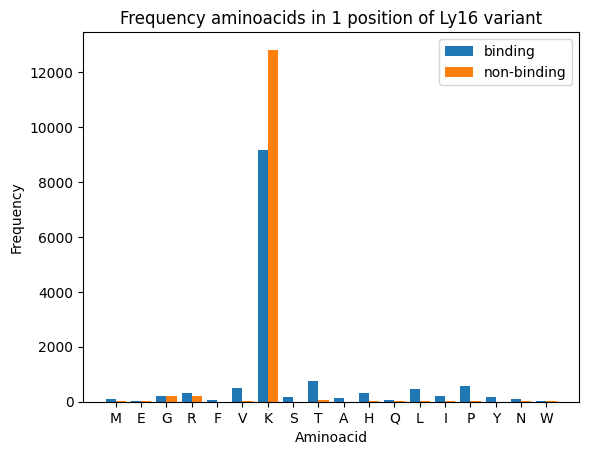

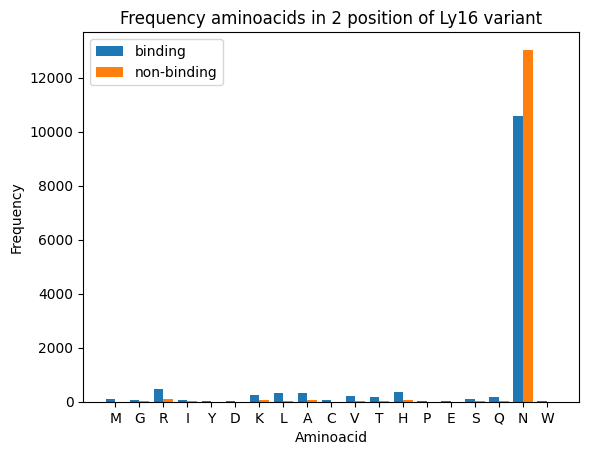

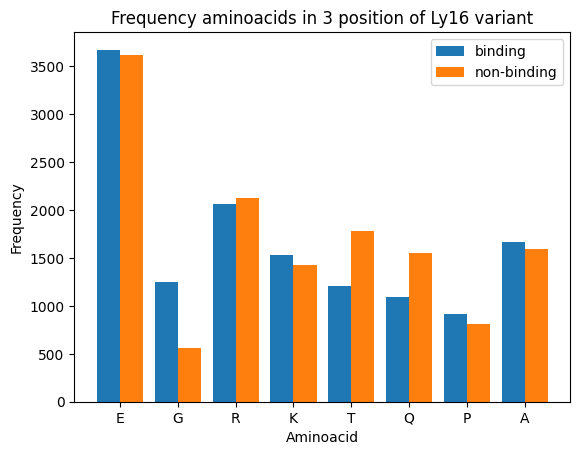

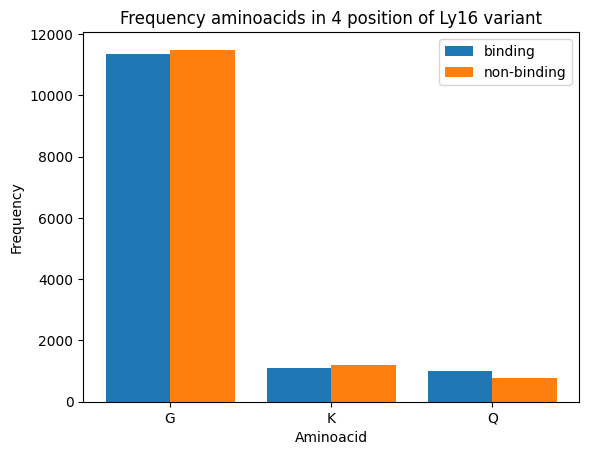

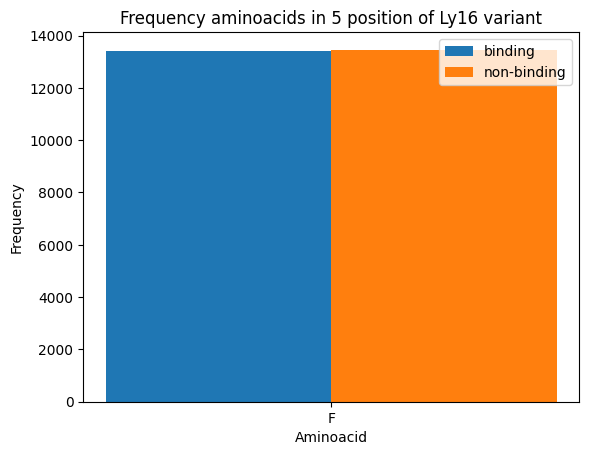

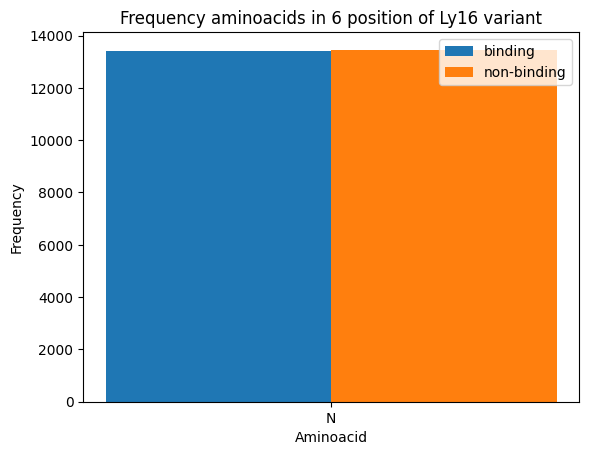

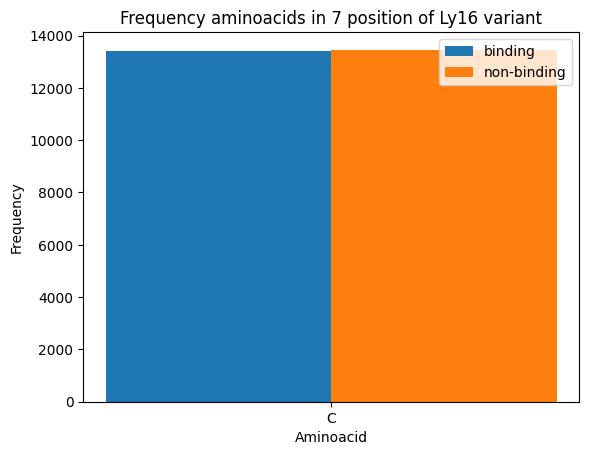

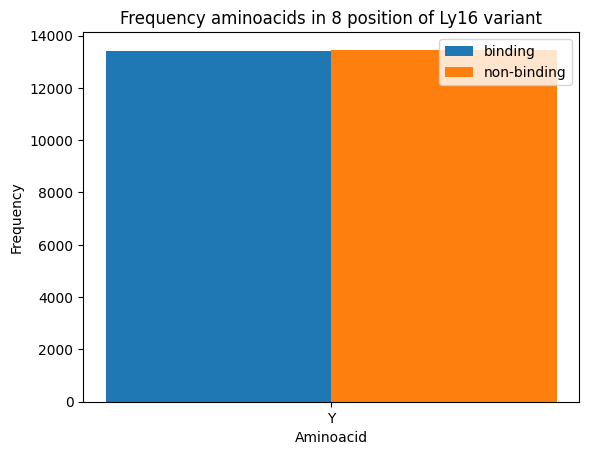

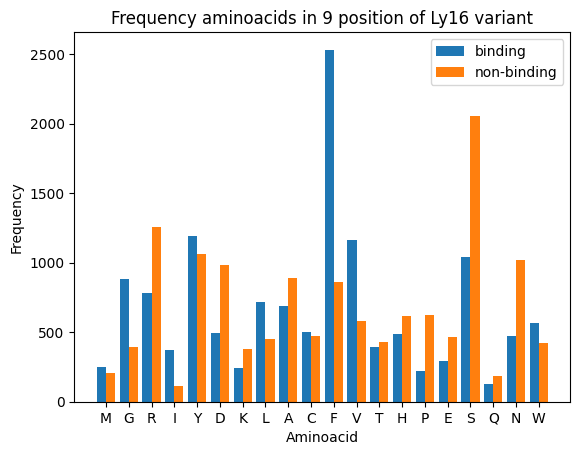

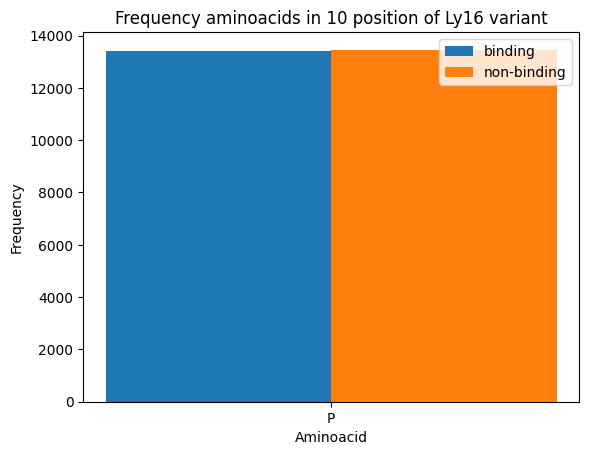

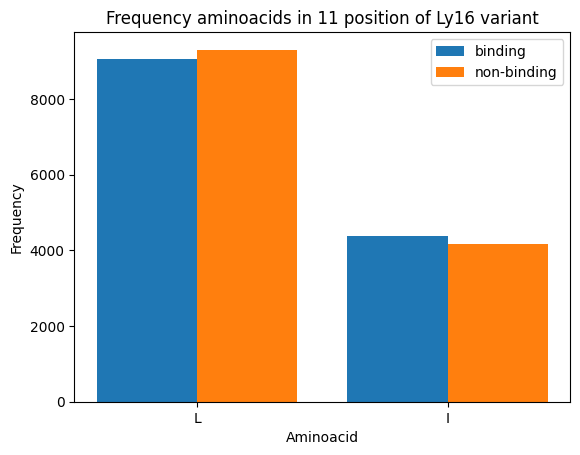

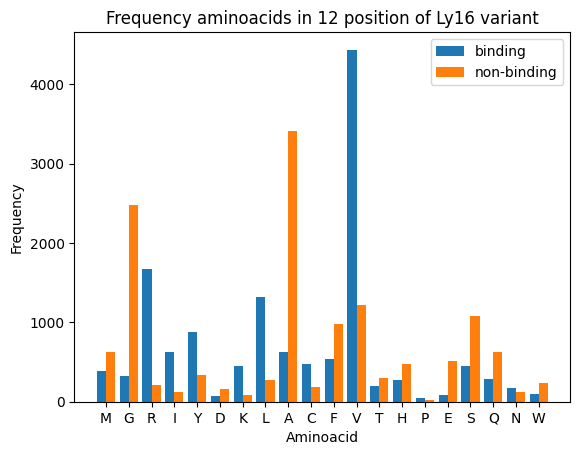

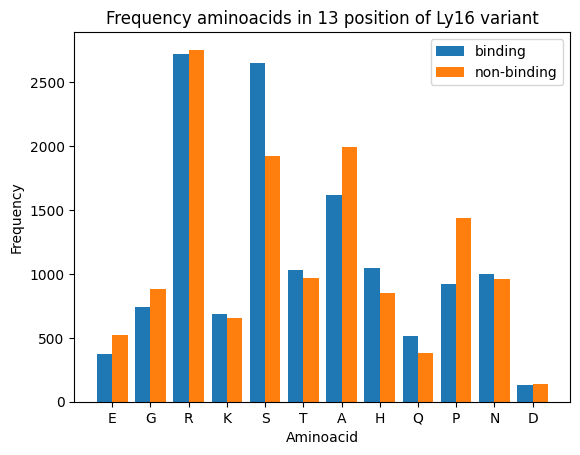

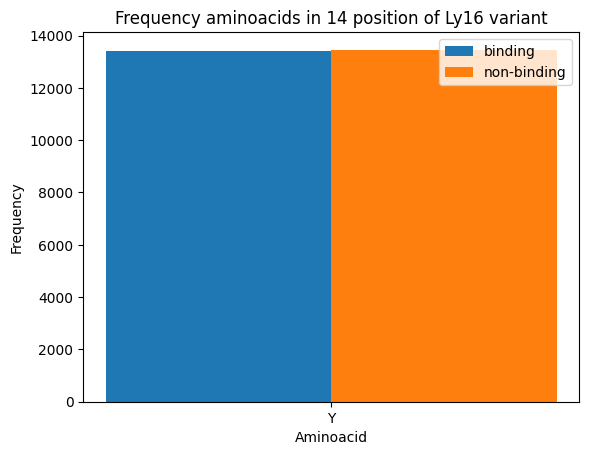

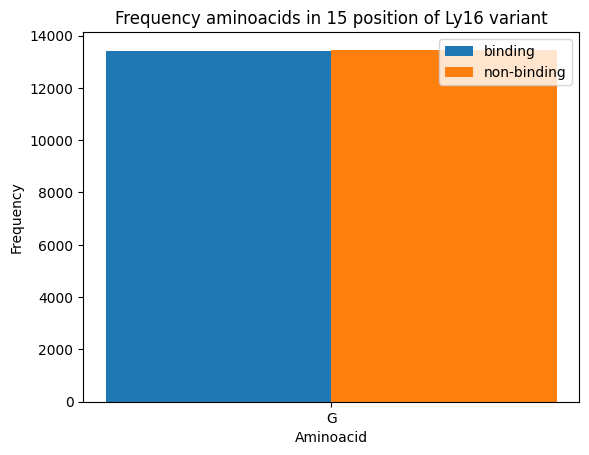

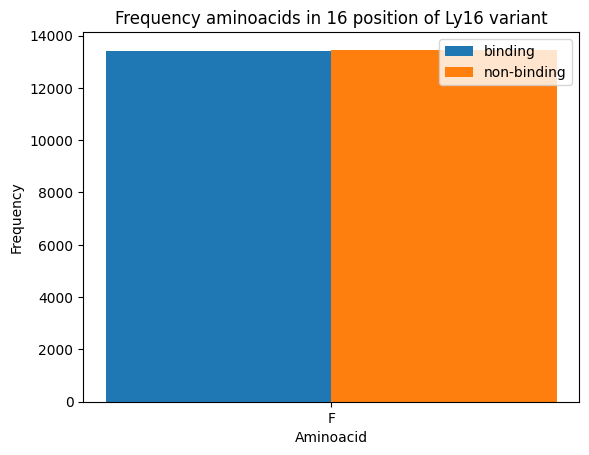

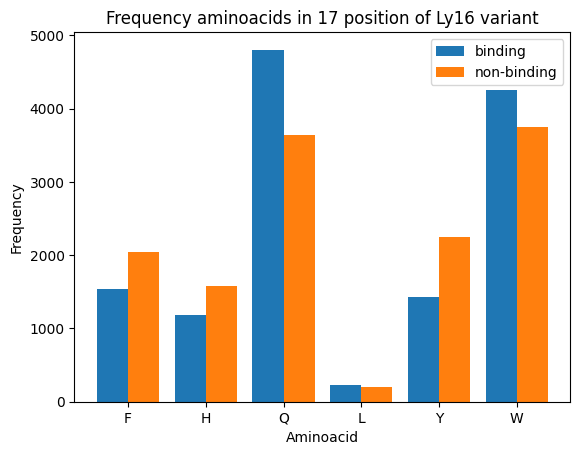

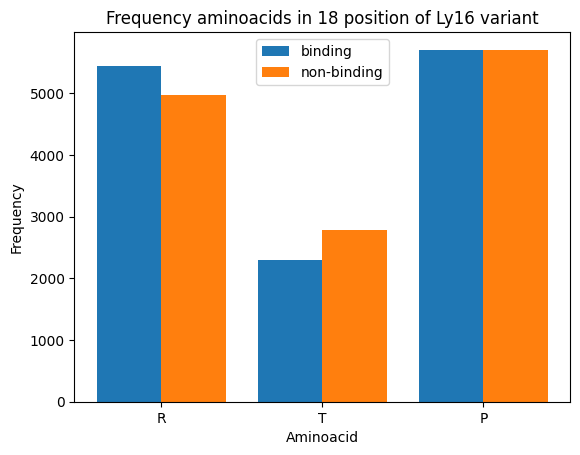

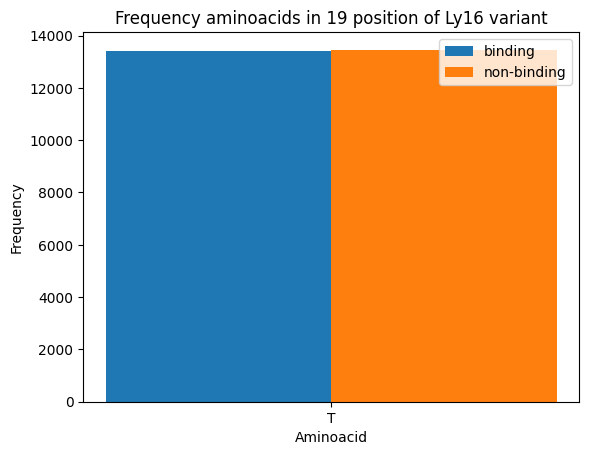

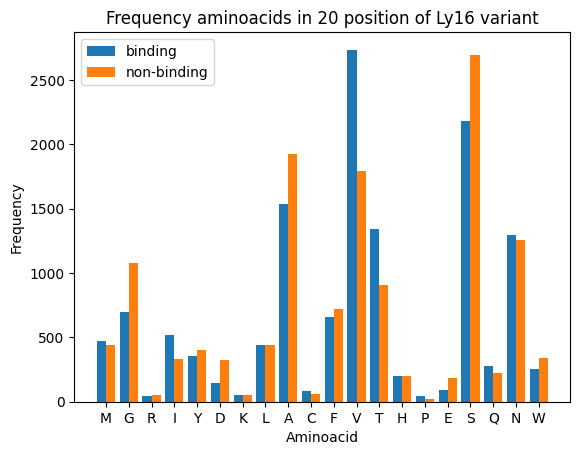

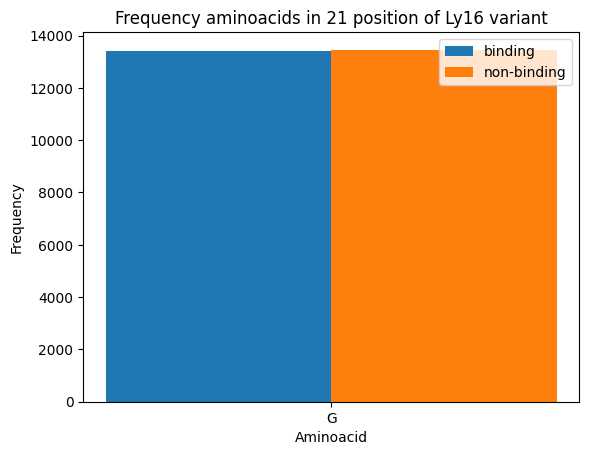

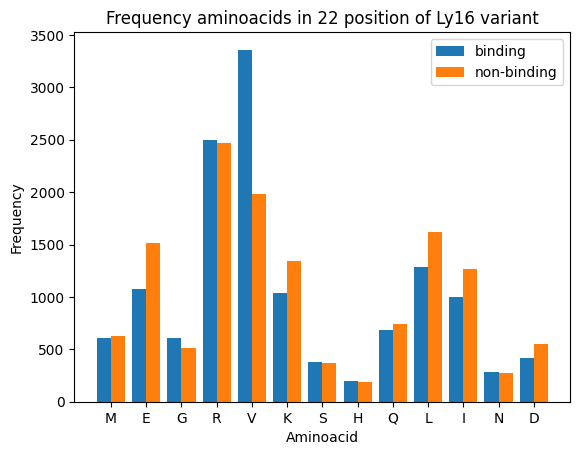

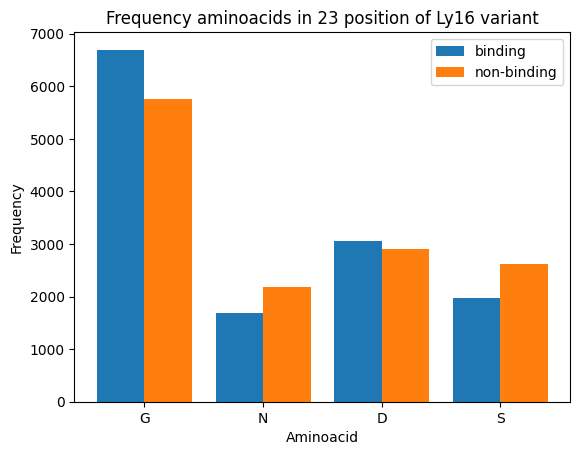

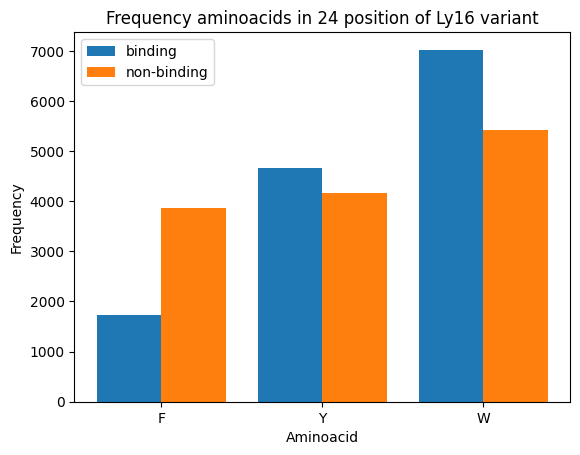

In [29]:
for pos in range(24):
    plot_distr(pos, freq_zeros_Ly16, freq_ones_Ly16, 'Ly16')
